# Hyperparameter tuning gradient boosting

## Context:
A company which is active in Big Data and Data Science wants to hire data scientists among people who successfully pass some courses which are conducted by the company. Many people sign up for their training. Company wants to know which of these candidates really want to work for the company after training, because it helps reducing the cost and time as well as increasing the quality of training and the planning of the courses. Information related to demographics, education, experience are in hands from candidates signup and enrollment.

## Features

* enrollee_id : Unique ID for candidate
* city: City code
* city_ development _index : Developement index of the city (scaled)
* gender: Gender of candidate
* relevent_experience: Relevant experience of candidate
* enrolled_university: Type of University course enrolled if any
* education_level: Education level of candidate
* major_discipline :Education major discipline of candidate
* experience: Candidate total experience in years
* company_size: No of employees in current employer's company
* company_type : Type of current employer
* lastnewjob: Difference in years between previous job and current job
* training_hours: training hours completed
* target: 0 – Not looking for job change, 1 – Looking for a job change

## Plan:

We will treat each column in two phases:
### Data preprocessing:
* Imputing missing values.
* Handling categorical data.
    
### Data Visualization

### Model Creation:

Then we will test several model and choose the one with the best performance:
* Models: Logistic Regression-SVM-Gradient Boosting-KNN-RandomForest-XGBoost classifier.
* Hyperparameter tuning.
* Use the model to predict target column in Test set.

## Imports¶

Lets get started, first lets import our typical libraries:

In [25]:
import numpy as np
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
import warnings

warnings.filterwarnings("ignore")

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
print("Setup complete")

Setup complete


## Loading the data

Let's import our train and test data.

In [16]:
#Data
train = pd.read_csv("../../../assets/data/aug_train.csv")

#testing data
#test = pd.read_csv('../input/hr-analytics-job-change-of-data-scientists/aug_test.csv')

Let's take a closer look to our data.

In [17]:
train.head()

,enrollee_id,city,city_development_index,gender,relevent_experience,enrolled_university,education_level,major_discipline,experience,company_size,company_type,last_new_job,training_hours,target
0,8949,city_103,0.920,Male,Has relevent experience,no_enrollment,Graduate,STEM,>20,NaN,NaN,1,36,1.0
1,29725,city_40,0.776,Male,No relevent experience,no_enrollment,Graduate,STEM,15,50-99,Pvt Ltd,>4,47,0.0
2,11561,city_21,0.624,NaN,No relevent experience,Full time course,Graduate,STEM,5,NaN,NaN,never,83,0.0
3,33241,city_115,0.789,NaN,No relevent experience,NaN,Graduate,Business Degree,<1,NaN,Pvt Ltd,never,52,1.0
4,666,city_162,0.767,Male,Has relevent experience,no_enrollment,Masters,STEM,>20,50-99,Funded Startup,4,8,0.0


From the first glence we can see that most of the data is categorical, and we have several missing values in different columns.
Let's take a look at the number of missing values in each column:

In [18]:
print("Train data missing values: \n",train.isna().sum())

Train data missing values: 
 enrollee_id                  0
city                         0
city_development_index       0
gender                    4508
relevent_experience          0
enrolled_university        386
education_level            460
major_discipline          2813
experience                  65
company_size              5938
company_type              6140
last_new_job               423
training_hours               0
target                       0
dtype: int64


In [19]:
train.count()

enrollee_id               19158
city                      19158
city_development_index    19158
gender                    14650
relevent_experience       19158
enrolled_university       18772
education_level           18698
major_discipline          16345
experience                19093
company_size              13220
company_type              13018
last_new_job              18735
training_hours            19158
target                    19158
dtype: int64

## Exploratory data analysis

### Task 1: City

In [20]:
train["city"].unique()

array(['city_103', 'city_40', 'city_21', 'city_115', 'city_162',
       'city_176', 'city_160', 'city_46', 'city_61', 'city_114',
       'city_13', 'city_159', 'city_102', 'city_67', 'city_100',
       'city_16', 'city_71', 'city_104', 'city_64', 'city_101', 'city_83',
       'city_105', 'city_73', 'city_75', 'city_41', 'city_11', 'city_93',
       'city_90', 'city_36', 'city_20', 'city_57', 'city_152', 'city_19',
       'city_65', 'city_74', 'city_173', 'city_136', 'city_98', 'city_97',
       'city_50', 'city_138', 'city_82', 'city_157', 'city_89',
       'city_150', 'city_70', 'city_175', 'city_94', 'city_28', 'city_59',
       'city_165', 'city_145', 'city_142', 'city_26', 'city_12',
       'city_37', 'city_43', 'city_116', 'city_23', 'city_99', 'city_149',
       'city_10', 'city_45', 'city_80', 'city_128', 'city_158',
       'city_123', 'city_7', 'city_72', 'city_106', 'city_143', 'city_78',
       'city_109', 'city_24', 'city_134', 'city_48', 'city_144',
       'city_91', 'city_

We can see that every city has a specific number, with a prefix "city_", so first we have to delete the prefix then transform the data from object type to integer.

In [21]:
train['city'] = train['city'].map(lambda row: row.replace('city_',''))

In [22]:
train['city'] = train['city'].astype(int)

The result of cities

In [23]:
print(train["city"].unique())
print("We have {} unique variables:".format(len(train["city"].unique())))

[103  40  21 115 162 176 160  46  61 114  13 159 102  67 100  16  71 104
  64 101  83 105  73  75  41  11  93  90  36  20  57 152  19  65  74 173
 136  98  97  50 138  82 157  89 150  70 175  94  28  59 165 145 142  26
  12  37  43 116  23  99 149  10  45  80 128 158 123   7  72 106 143  78
 109  24 134  48 144  91 146 133 126 118   9 167  27  84  54  39  79  76
  77  81 131  44 117 155  33 141 127  62  53  25   2  69 120 111  30   1
 140 179  55  14  42 107  18 139 180 166 121 129   8  31 171]
We have 123 unique variables:


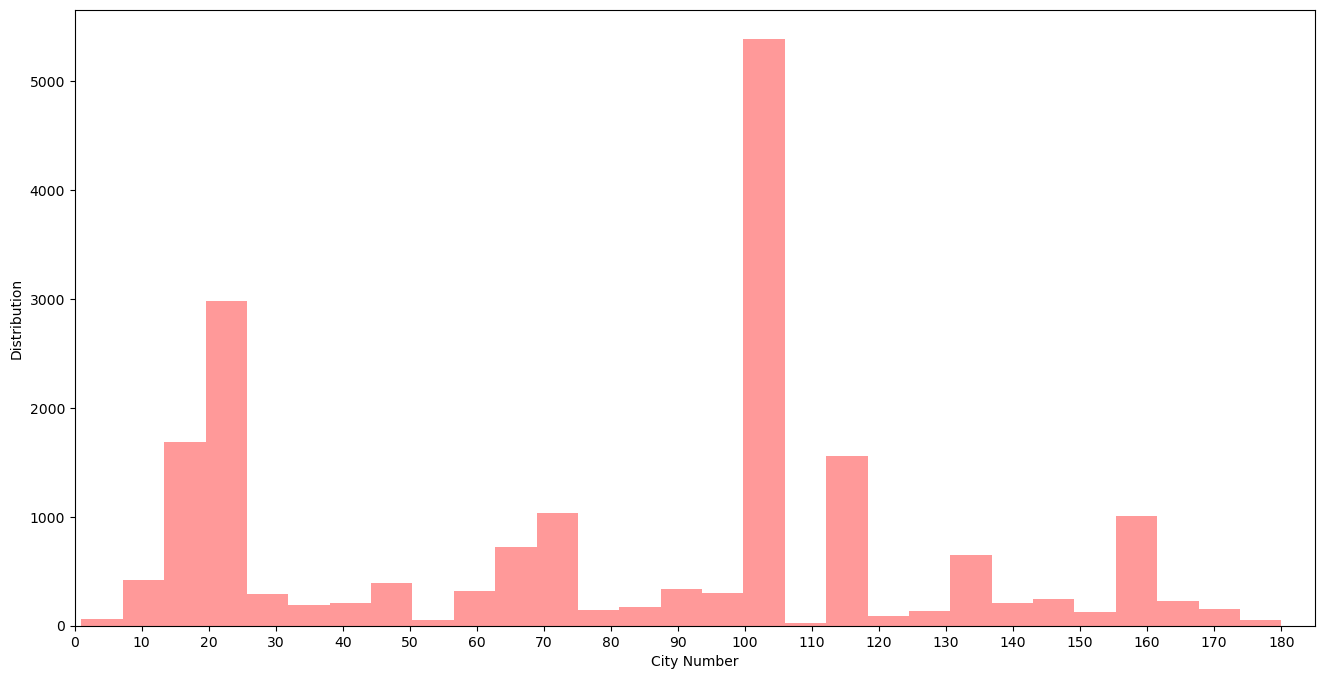

In [26]:
plt.figure(figsize=(16,8))
g = sns.distplot(train.city,kde=False, color="red")
g = (g.set(xlim=(0,185),xticks=range(0,190,10)))
plt.xlabel("City Number")
plt.ylabel("Distribution")
plt.show()

In [27]:
print("Most common cities are:\n",train['city'].value_counts())

Most common cities are:
 103    4355
21     2702
16     1533
114    1336
160     845
       ... 
129       3
111       3
121       3
140       1
171       1
Name: city, Length: 123, dtype: int64


We can see that candidates from the city number **103** are the majority.

In [28]:
train.sort_values(by='city')

,enrollee_id,city,city_development_index,gender,relevent_experience,enrolled_university,education_level,major_discipline,experience,company_size,company_type,last_new_job,training_hours,target
18720,15314,1,0.847,Male,No relevent experience,Full time course,Graduate,STEM,5,100-500,Pvt Ltd,1,13,0.0
4669,14020,1,0.847,Male,Has relevent experience,no_enrollment,Masters,STEM,10,50-99,Pvt Ltd,1,59,0.0
14300,20753,1,0.847,Male,No relevent experience,Full time course,High School,NaN,4,10000+,Pvt Ltd,1,114,0.0
15172,14791,1,0.847,Male,Has relevent experience,Full time course,Graduate,STEM,10,5000-9999,Pvt Ltd,1,9,0.0
5723,6476,1,0.847,Male,No relevent experience,Full time course,Graduate,STEM,11,NaN,NaN,3,194,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12531,27283,180,0.698,NaN,No relevent experience,no_enrollment,Graduate,STEM,2,NaN,NaN,never,13,0.0
12040,9339,180,0.698,Male,Has relevent experience,no_enrollment,Graduate,STEM,3,NaN,NaN,3,57,0.0
18477,12647,180,0.698,NaN,No relevent experience,no_enrollment,Graduate,STEM,3,<10,Pvt Ltd,2,43,0.0
11444,9053,180,0.698,NaN,No relevent experience,Full time course,Graduate,STEM,1,NaN,NaN,1,77,0.0


And here we can see that each city has specific city_development_index, so deleting this column won't make any difference to the model, however we can visualize what is the development index for the cities with the majority of candidates:

In [29]:
train.loc[train.city == 103,'city_development_index']

0        0.92
8        0.92
9        0.92
11       0.92
16       0.92
         ... 
19146    0.92
19149    0.92
19152    0.92
19154    0.92
19155    0.92
Name: city_development_index, Length: 4355, dtype: float64

So the city with the majority of candidates is a well developped city, but do we have a relationship between the city development index and the chance of the candidate looking for another job?

In [30]:
train['city'] = train['city'].astype(np.int8)

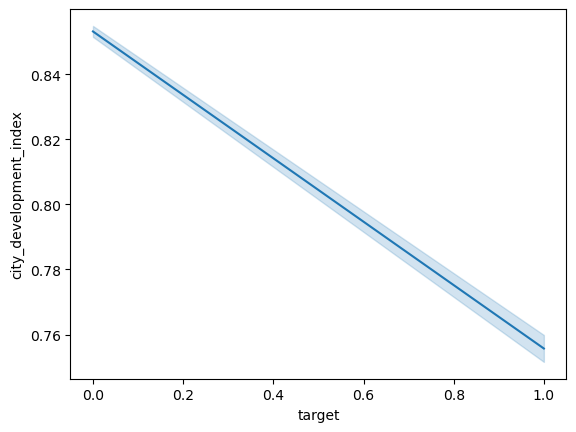

In [31]:
sns.lineplot(x='target', y='city_development_index',data=train)
plt.show()

The candidates from cities with low development index tend to look for a job change and vice versa. Now let's just drop this column.

In [32]:
train = train.drop(labels='city_development_index', axis=1)

### Task2: Gender

It is obvious we have to encode the caregorical data and take care of missing data, there are a lot of ways to handle gender missing values such as replacing them with most common gender in the dataset, deleting those rows...etc.
But I prefer to fill the gender missing values with "Other" since we may have candidates identify as non-binary.
First lets take a look at our gender column:

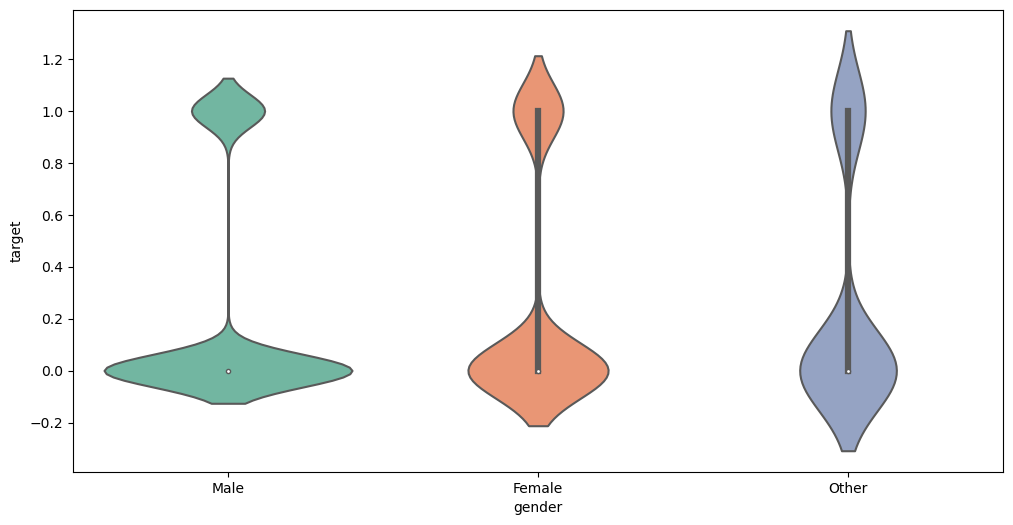

In [33]:
plt.figure(figsize=(12,6))
sns.violinplot(x='gender', y='target', palette='Set2', data=train)
plt.show()

It looks like more men don't look for a job change but actually we can't conclude that from this violinplot since most of the candidates are men.

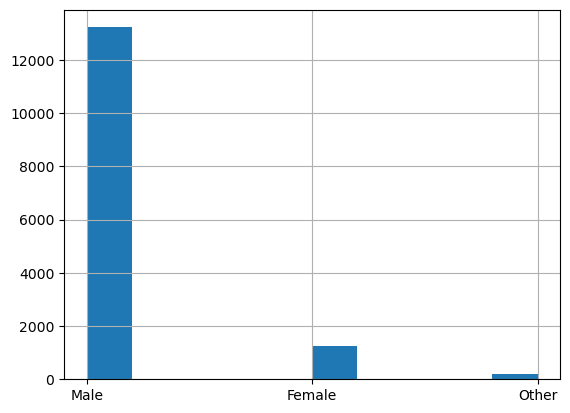

In [34]:
train['gender'].hist()
plt.show()

Now let's fill the missing values with 'Other':

In [35]:
train['gender'] = train['gender'].fillna('Other')

Since we don't have any missing values left in the gender column, let's encode the column, I will use for this one LabelEncoder of sklearn:

In [36]:
from sklearn.preprocessing import LabelEncoder

In [37]:
label_encoder = LabelEncoder()
train["gender"] = label_encoder.fit_transform(train["gender"])

- Female : 0
- Male : 1
- Other : 2

Lets have a look at what we have achieved so far:

In [38]:
train.isna().sum()

enrollee_id               0
city                      0
gender                    0
relevent_experience       0
enrolled_university     386
education_level         460
major_discipline       2813
experience               65
company_size           5938
company_type           6140
last_new_job            423
training_hours            0
target                    0
dtype: int64

In [39]:
train.head()

,enrollee_id,city,gender,relevent_experience,enrolled_university,education_level,major_discipline,experience,company_size,company_type,last_new_job,training_hours,target
0,8949,103,1,Has relevent experience,no_enrollment,Graduate,STEM,>20,NaN,NaN,1,36,1.0
1,29725,40,1,No relevent experience,no_enrollment,Graduate,STEM,15,50-99,Pvt Ltd,>4,47,0.0
2,11561,21,2,No relevent experience,Full time course,Graduate,STEM,5,NaN,NaN,never,83,0.0
3,33241,115,2,No relevent experience,NaN,Graduate,Business Degree,<1,NaN,Pvt Ltd,never,52,1.0
4,666,-94,1,Has relevent experience,no_enrollment,Masters,STEM,>20,50-99,Funded Startup,4,8,0.0


### Task 3：Relevant experience

Before making any decision we have to look at the values of this column:

In [40]:
train['relevent_experience'].unique()

array(['Has relevent experience', 'No relevent experience'], dtype=object)

So it only has two values, and no missing data.

Encoding:

In [59]:
train["relevent_experience"] = train["relevent_experience"].map({"Has relevent experience":1, "No relevent experience":0})

### Encoding:

In [25]:
train["relevent_experience"] = train["relevent_experience"].map({"Has relevent experience":1, "No relevent experience":0})

### Task 4: Enrolled university

In [41]:
train['enrolled_university'].unique()

array(['no_enrollment', 'Full time course', nan, 'Part time course'],
      dtype=object)

This column has missing values, lets take care of them before encoding.

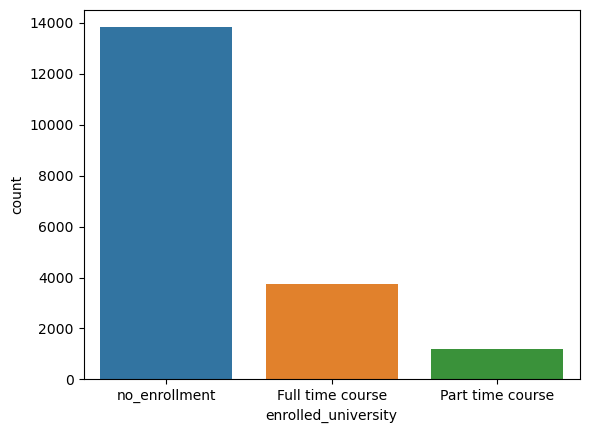

In [42]:
sns.countplot(x='enrolled_university', data=train)
plt.show()

Most of the candidates had no university enrollment

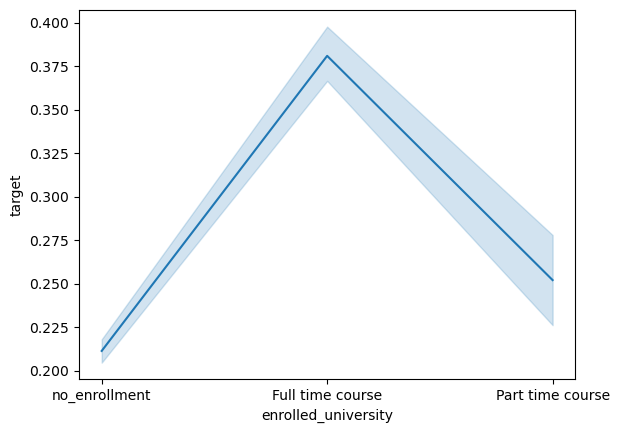

In [43]:
sns.lineplot(x='enrolled_university', y='target', palette='Set2', data=train)
plt.show()

We can see that most of candidates had no enrollment more likely aren't looking for a job change.

We can't tell if the missing data is left out or the candidates had no enrollment, but also we don't want to create a new value (like 'OTHER') because it can create a pattern that doesn't exist.
I will fill the missing values with the no_enrollment value.

In [44]:
train["enrolled_university"]=train["enrolled_university"].fillna('no_enrollment')

Encode:

In [45]:
train["enrolled_university"] = label_encoder.fit_transform(train["enrolled_university"])

### Task 5: Education level

In [46]:
train['education_level'].unique()

array(['Graduate', 'Masters', 'High School', nan, 'Phd', 'Primary School'],
      dtype=object)

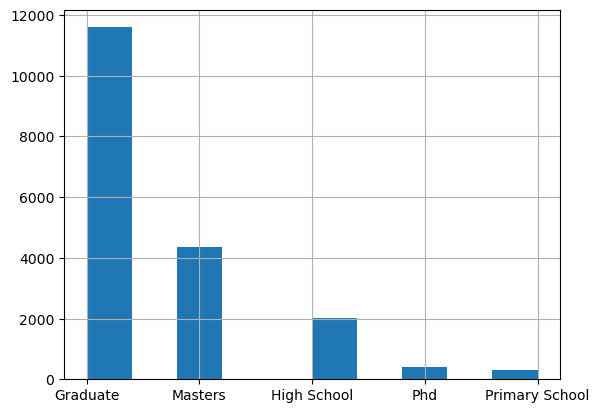

In [47]:
train['education_level'].hist()
plt.show()

Most candidates are graduates.

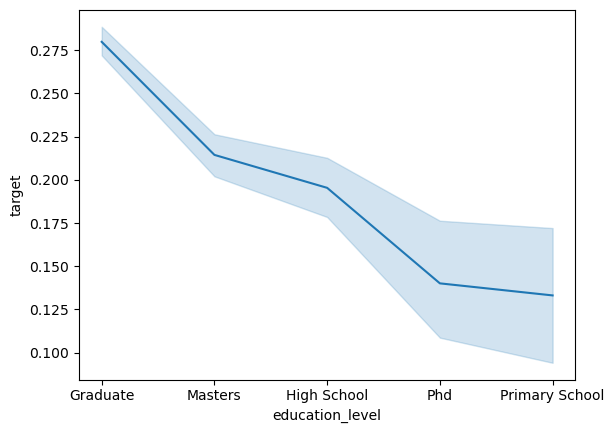

In [48]:
sns.lineplot(x='education_level', y='target', palette='Set2', data=train)
plt.show()

Graduates and Masters are most likely to look for a job change, but people with Phd or primary school aren't.

In [49]:
train["education_level"]=train["education_level"].fillna('Other')

In [50]:
train["education_level"] = label_encoder.fit_transform(train["education_level"])

### Task 6: Major discipline

In [51]:
train['major_discipline'].unique()

array(['STEM', 'Business Degree', nan, 'Arts', 'Humanities', 'No Major',
       'Other'], dtype=object)

**STEM:** Science, technology, engineering, and mathematics

<Axes: >

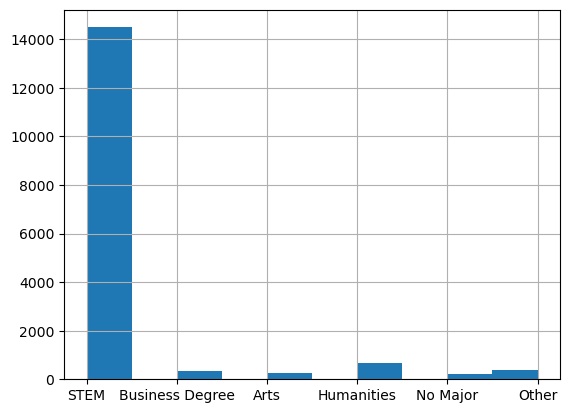

In [52]:
train['major_discipline'].hist()

Most of our candidates are STEM majors.

In [53]:
train['major_discipline'] = train['major_discipline'].fillna('Other')

In [54]:
train["major_discipline"] = label_encoder.fit_transform(train["major_discipline"])

In [55]:
train.head()

,enrollee_id,city,gender,relevent_experience,enrolled_university,education_level,major_discipline,experience,company_size,company_type,last_new_job,training_hours,target
0,8949,103,1,Has relevent experience,2,0,5,>20,NaN,NaN,1,36,1.0
1,29725,40,1,No relevent experience,2,0,5,15,50-99,Pvt Ltd,>4,47,0.0
2,11561,21,2,No relevent experience,0,0,5,5,NaN,NaN,never,83,0.0
3,33241,115,2,No relevent experience,2,0,1,<1,NaN,Pvt Ltd,never,52,1.0
4,666,-94,1,Has relevent experience,2,2,5,>20,50-99,Funded Startup,4,8,0.0


### Task 7: Experience

The experience variable is an object indicating the minimum or maximum years of experience a candidate had, so deleting the operators won't make a big difference.

First we have to convert the column to string.

In [60]:
train['experience'] = train['experience'].astype(str)

In [61]:
train['experience'] = train['experience'].apply(lambda col: col.replace('>',''))
train['experience'] = train['experience'].apply(lambda col: col.replace('<',''))

Delete the symbols.

In [62]:
train.head()

,enrollee_id,city,gender,relevent_experience,enrolled_university,education_level,major_discipline,experience,company_size,company_type,last_new_job,training_hours,target
0,8949,103,1,1,2,0,5,20,NaN,NaN,1,36,1.0
1,29725,40,1,0,2,0,5,15,50-99,Pvt Ltd,>4,47,0.0
2,11561,21,2,0,0,0,5,5,NaN,NaN,never,83,0.0
3,33241,115,2,0,2,0,1,1,NaN,Pvt Ltd,never,52,1.0
4,666,-94,1,1,2,2,5,20,50-99,Funded Startup,4,8,0.0


Lets fill the missing values with 0.

In [63]:
train['experience'] = train['experience'].apply(lambda col: col.replace('nan','0'))

Convert the values to Integer.

In [64]:
train['experience'] = pd.to_numeric(train['experience'])

### Task 8:Company size

In [65]:
train['company_size'].unique()

array([nan, '50-99', '<10', '10000+', '5000-9999', '1000-4999', '10/49',
       '100-500', '500-999'], dtype=object)

We have 5938 missing values in the company_size column, before encoding categorical data we have to handle the missing values.

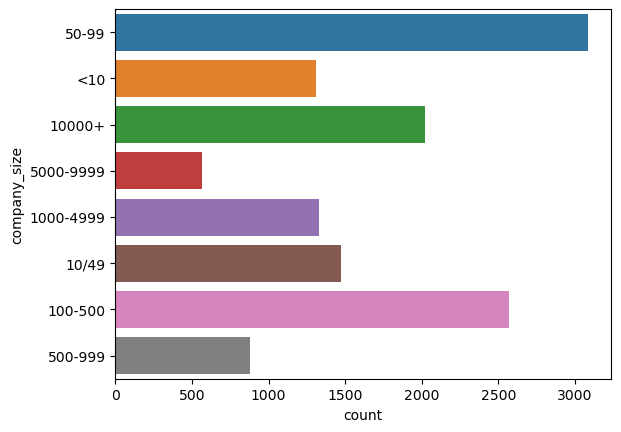

In [66]:
sns.countplot(y='company_size', data=train)
plt.show()

#### We can see that most candidates work in small companies (between 50-500)

Identify each interval with a number:

In [67]:
train['company_size'] = train['company_size'].map({"50-99":0, "<10":1, "10000+":2, "5000-9999":3, "1000-4999":4, "10/49":5, "100-500":6, "500-999":7})

In [68]:
train.shape

(19158, 13)

30% of candidates didn't mention if they had experience or not, so we will assume that these candidates have no experience.

In [69]:
train['company_size'] = train['company_size'].fillna(8)

### Task 9:Company type

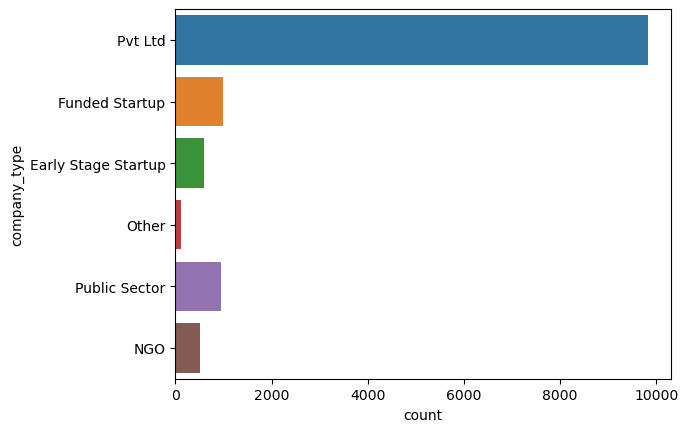

In [70]:
sns.countplot(y='company_type', data=train)
plt.show()

Most of candidates work in Private limited company type (pvt ltd)

In [72]:
train['company_type'] = train['company_type'].map({"Pvt Ltd":0, "Funded Startup":1, "Early Stage Startup":2, "Public Sector":3, "NGO":4, "Other":5})

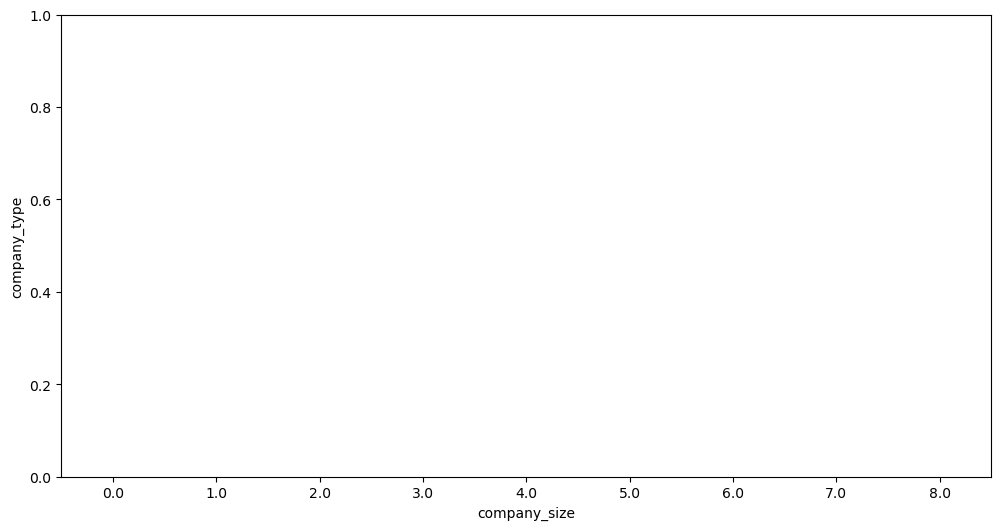

In [73]:
plt.figure(figsize=(12,6))
sns.violinplot(x='company_size', y='company_type',data=train)
plt.show()

Private limited companies are of different sizes, from less than ten people to +10 000! So we can't really find a relation between company size and type.
We will fill missing values in company_type with 0(private limited comapany).

In [74]:
train['company_type'] = train['company_type'].fillna(0)

### Task 10: Last new job

In [75]:
train['last_new_job'].unique()

array(['1', '>4', 'never', '4', '3', '2', nan], dtype=object)

We assume that missing values are from candidates that had no job.

In [76]:
train['last_new_job'] = train['last_new_job'].fillna('never')

In [77]:
train['last_new_job'] = train['last_new_job'].map({"1":1, ">4": 5, "never":0, "4":4, "3":3, "2":2})

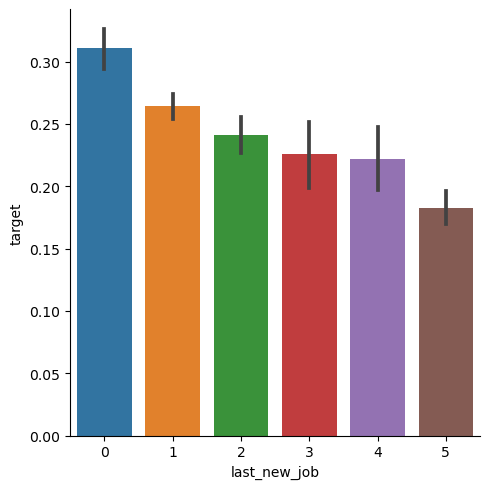

In [78]:
g = sns.catplot(y="target",x="last_new_job",data=train, kind="bar")

So we have taken care of all categorical data and missing values, lets take a look at what we have done so far:

In [80]:
train.head()

,enrollee_id,city,gender,relevent_experience,enrolled_university,education_level,major_discipline,experience,company_size,company_type,last_new_job,training_hours,target
0,8949,103,1,1,2,0,5,20,8.0,0.0,1,36,1.0
1,29725,40,1,0,2,0,5,15,0.0,0.0,5,47,0.0
2,11561,21,2,0,0,0,5,5,8.0,0.0,0,83,0.0
3,33241,115,2,0,2,0,1,1,8.0,0.0,0,52,1.0
4,666,-94,1,1,2,2,5,20,0.0,0.0,4,8,0.0


In [81]:
train.dtypes

enrollee_id              int64
city                      int8
gender                   int64
relevent_experience      int64
enrolled_university      int64
education_level          int64
major_discipline         int64
experience               int64
company_size           float64
company_type           float64
last_new_job             int64
training_hours           int64
target                 float64
dtype: object

### Task 11: Pre modeling steps

In [82]:
pred = train['target']

In [83]:
train = train.drop(labels='target', axis=1)

In [84]:
train = train.astype(np.int8)

## Models testing

In [85]:
from sklearn.pipeline import Pipeline
from sklearn import svm
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
import xgboost as xgb
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn import metrics
from sklearn.model_selection import KFold, cross_val_score, train_test_split

Lets try different models and see what works best:

In [87]:
KFold_Score = pd.DataFrame()
classifiers = ['Linear SVM', 'LogisticRegression', 'RandomForestClassifier', 'XGBoostClassifier','GradientBoostingClassifier']
models = [svm.SVC(kernel='linear'),
          LogisticRegression(max_iter = 1000),
          RandomForestClassifier(n_estimators=200, random_state=0),
          xgb.XGBClassifier(n_estimators=100),
          GradientBoostingClassifier(random_state=0)
         ]

In [88]:
j = 0
for i in models:
    model = i
    cv = KFold(n_splits=5, random_state=0, shuffle=True)
    KFold_Score[classifiers[j]] = (cross_val_score(model, train, np.ravel(pred), scoring = 'accuracy', cv=cv))
    j = j+1

In [90]:
mean = pd.DataFrame(KFold_Score.mean(), index= classifiers)
KFold_Score = pd.concat([KFold_Score,mean.T])
KFold_Score.index=['Fold 1','Fold 2','Fold 3','Fold 4','Fold 5','Mean']
KFold_Score.T.sort_values(by=['Mean'], ascending = False)

,Fold 1,Fold 2,Fold 3,Fold 4,Fold 5,Mean
GradientBoostingClassifier,0.781054,0.772704,0.783403,0.801879,0.786218,0.785052
XGBoostClassifier,0.779228,0.771399,0.776879,0.782563,0.776821,0.777378
RandomForestClassifier,0.769572,0.765136,0.771660,0.780475,0.780475,0.773464
LogisticRegression,0.751305,0.748434,0.761743,0.762464,0.749674,0.754724
Linear SVM,0.752088,0.743737,0.756785,0.755938,0.744714,0.750652


Obviously,Gradient Boosting gives the best result.

## Boosting:

**Ensemble learning techniques:** They combine the predictions of multiple machine learning models.

**Boosting:** Boosting algorithms play a crucial role in dealing with bias variance trade-off.  Unlike bagging algorithms, which only controls for high variance in a model, boosting controls both the aspects (bias & variance), and is considered to be more effective.
Boosting is an ensemble learning technique.

Boosting is a sequential technique which works on the principle of ensemble. It combines a set of weak learners and delivers improved prediction accuracy. At any instant t, the model outcomes are weighed based on the outcomes of previous instant t-1. The outcomes predicted correctly are given a lower weight and the ones miss-classified are weighted higher.


**Visually:**

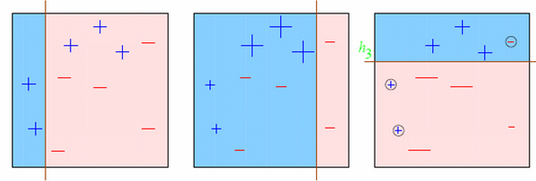

<a href="https://ibb.co/PgstW8k"><img src="https://i.ibb.co/WfNsz1C/boosting.png" alt="boosting" border="0"></a>

## Gradient Boosting:

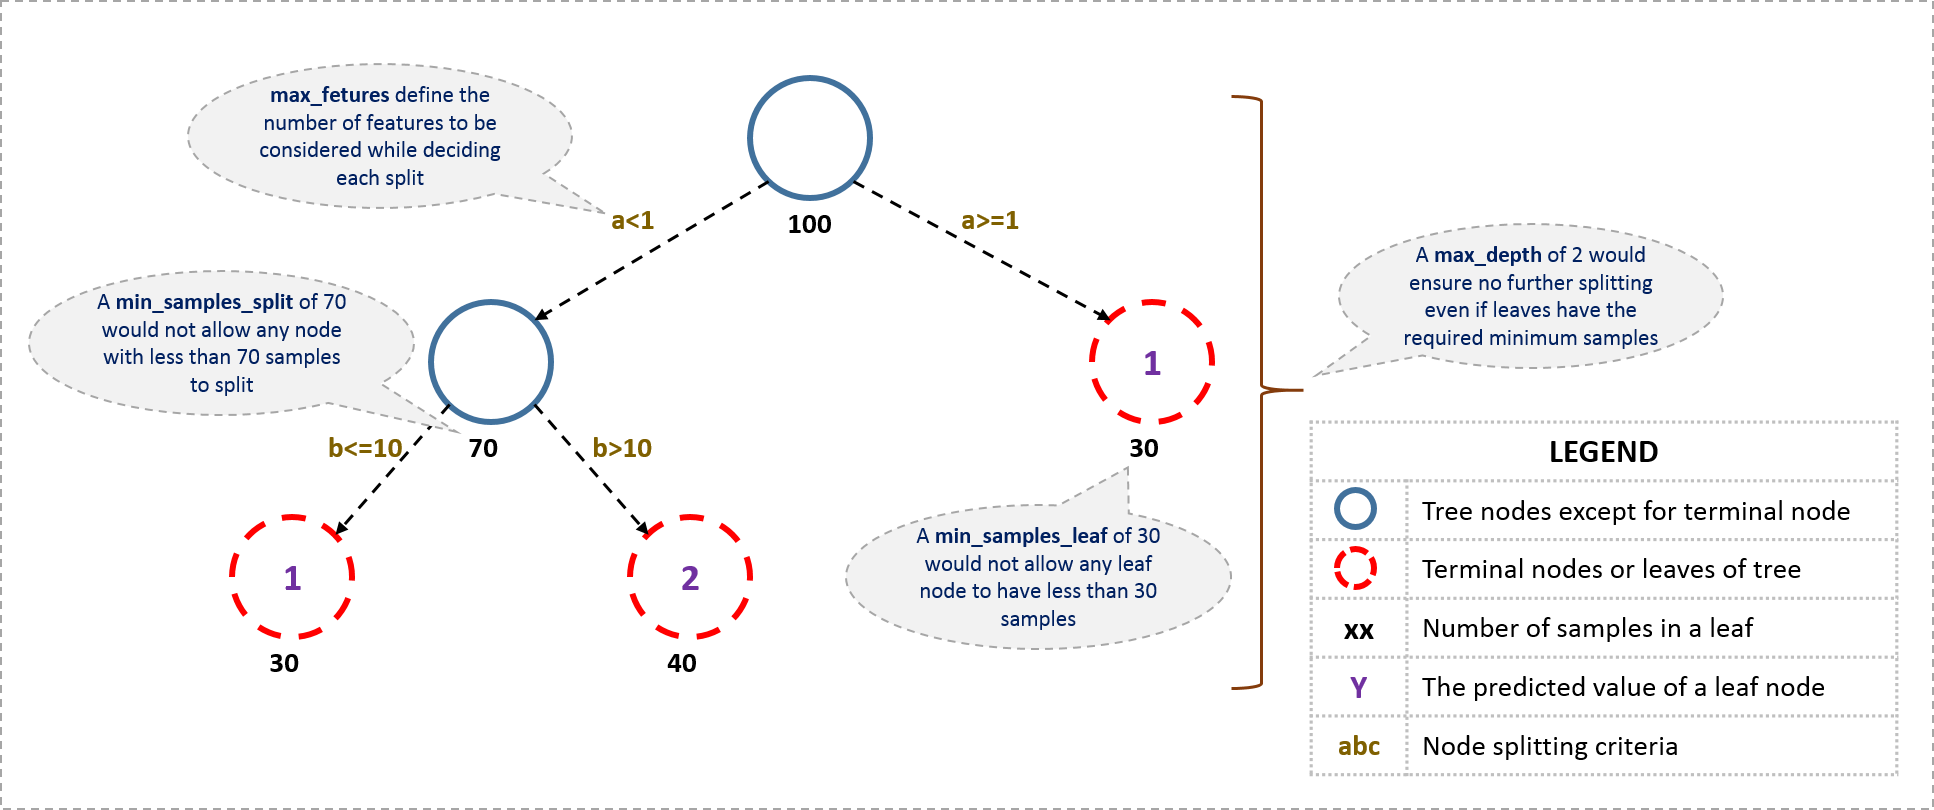

The overall parameters of gradient boosting can be devided into three categories:
* Tree-Specific Parameters: These affect each individual tree in the model.
* Boosting Parameters: These affect the boosting operation in the model.
* Miscellaneous Parameters: Other parameters for overall functioning.

### Tree-specific parameters

### Boosting parameters:

* learning_rate
* n_estimators
* subsample

### Miscellaneous parameters

* loss
* init
* random_state
* verbose

*Boosting reference:* https://www.analyticsvidhya.com/blog/2016/02/complete-guide-parameter-tuning-gradient-boosting-gbm-python/

*Patrick Winston, MIT:* https://www.youtube.com/watch?v=UHBmv7qCey4

## Hyperparameter Tuning using GridSearchCV

**GradientBoostingClassifier**(*, loss='deviance', learning_rate=0.1, n_estimators=100, subsample=1.0, criterion='friedman_mse', min_samples_split=2, min_samples_leaf=1, min_weight_fraction_leaf=0.0, max_depth=3, min_impurity_decrease=0.0, min_impurity_split=None, init=None, random_state=None, max_features=None, verbose=0, max_leaf_nodes=None, warm_start=False, validation_fraction=0.1, n_iter_no_change=None, tol=0.0001, ccp_alpha=0.0)

Grid search is best described as exhuastive guess and check. We have a problem: find the hyperparameters that result in the best cross validation score, and a set of values to try in the hyperparameter grid - the domain. The grid search method for finding the answer is to try all combinations of values in the domain and hope that the best combination is in the grid (in reality, we will never know if we found the best settings unless we have an infinite hyperparameter grid which would then require an infinite amount of time to run).

Grid search suffers from one limiting problem: it is extremely computationally expensive because we have to perform cross validation with every single combination of hyperparameters in the grid!

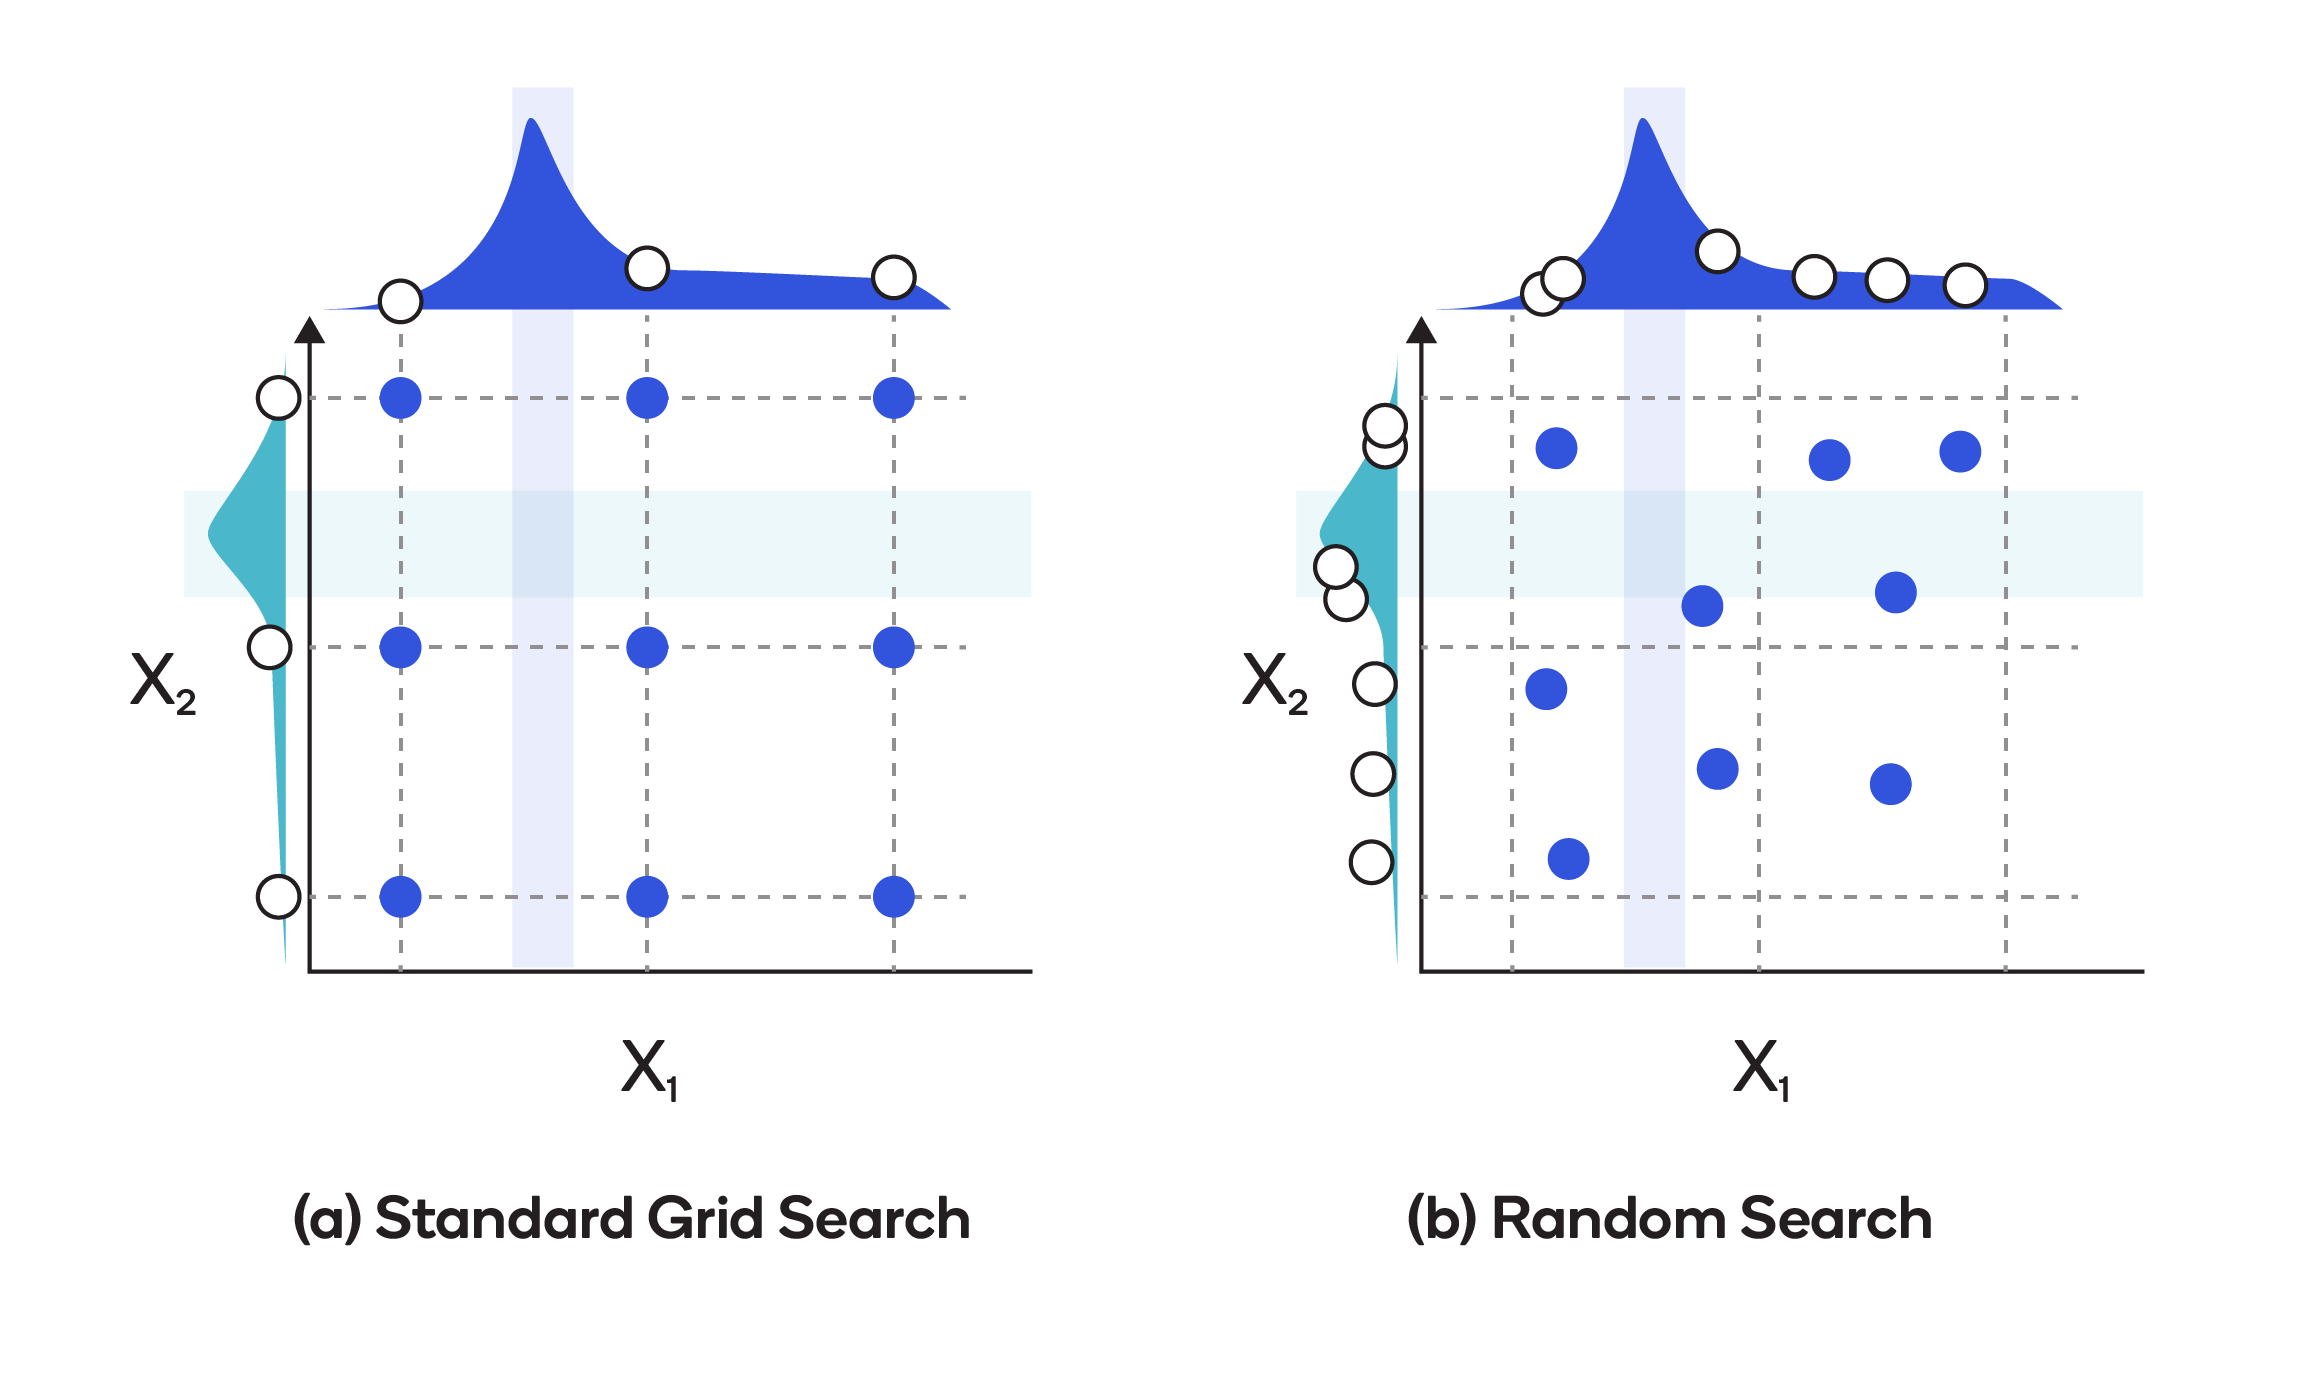

**Pros:**
- We don't have to write a long (nested for loops) code.
- Finds the best model within the grid.

**Cons:**
- Computationally expensive.
- It is 'uninformed'. Results of one model don't help creating the next model.

### Task 1: Initialize model

In [91]:
X_train, X_test, y_train, y_test = train_test_split(train, pred, test_size=0.3, random_state=42)

Lets initialize our model with these parameters:

In [92]:
y_train.head()

8253     0.0
10067    0.0
1851     0.0
4139     1.0
2473     0.0
Name: target, dtype: float64

In [93]:
mymodel = GradientBoostingClassifier(learning_rate=0.1, min_samples_split=500,min_samples_leaf=50,max_depth=8,max_features='sqrt',subsample=0.8,random_state=10)

### Task 2: Remove enrollee_id

We shouldn't use the enrollee_id since it is unique for each candidate.

In [94]:
predictors = [x for x in X_train.columns if x not in ["enrollee_id"]]

In [95]:
predictors

['city',
 'gender',
 'relevent_experience',
 'enrolled_university',
 'education_level',
 'major_discipline',
 'experience',
 'company_size',
 'company_type',
 'last_new_job',
 'training_hours']

### Task 3: Look for optimal number

First we have to look for an optimal number of estimators:

In [96]:
param_test1 = {'n_estimators':range(10,100,10)}

Grid search:

In [101]:
from sklearn.model_selection import GridSearchCV
CV_gbc = GridSearchCV(estimator=mymodel, param_grid=param_test1, scoring='roc_auc',n_jobs=4, cv= 5)
CV_gbc.fit(X_train[predictors],y_train)
CV_gbc.best_params_, CV_gbc.best_score_

({'n_estimators': 90}, 0.7975093854342419)

In [102]:
CV_gbc.cv_results_

{'mean_fit_time': array([0.05736938, 0.10874381, 0.16371784, 0.21915154, 0.27412739,
        0.32737083, 0.38016644, 0.43397346, 0.48781238]),
 'std_fit_time': array([0.0019358 , 0.00093104, 0.00088441, 0.00104967, 0.00179945,
        0.00067474, 0.00142339, 0.0024866 , 0.00733036]),
 'mean_score_time': array([0.00430479, 0.00407629, 0.00493507, 0.00580411, 0.00664454,
        0.00747619, 0.00833669, 0.00917621, 0.00977445]),
 'std_score_time': array([7.45868915e-04, 8.90325846e-05, 1.14861352e-05, 6.29869940e-05,
        3.28282212e-05, 7.63591250e-05, 3.89997996e-05, 6.45092829e-05,
        2.27765700e-04]),
 'param_n_estimators': masked_array(data=[10, 20, 30, 40, 50, 60, 70, 80, 90],
              mask=[False, False, False, False, False, False, False, False,
                    False],
        fill_value='?',
             dtype=object),
 'params': [{'n_estimators': 10},
  {'n_estimators': 20},
  {'n_estimators': 30},
  {'n_estimators': 40},
  {'n_estimators': 50},
  {'n_estimators'

In [103]:
dir(CV_gbc)

['__abstractmethods__',
 '__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getstate__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__setstate__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_abc_impl',
 '_check_feature_names',
 '_check_n_features',
 '_check_refit_for_multimetric',
 '_estimator_type',
 '_format_results',
 '_get_param_names',
 '_get_tags',
 '_more_tags',
 '_repr_html_',
 '_repr_html_inner',
 '_repr_mimebundle_',
 '_required_parameters',
 '_run_search',
 '_select_best_index',
 '_validate_data',
 '_validate_params',
 'best_estimator_',
 'best_index_',
 'best_params_',
 'best_score_',
 'classes_',
 'cv',
 'cv_results_',
 'decision_function',
 'error_score',
 'estimator',
 'feature_names_in_',
 'fit',
 'get_params',
 'inverse_transform',
 

### Task 4: Find learning rate

As you can see that here we got 90 as the optimal estimators for 0.1 learning rate, it is close to 100 so we will increase the learning rate to 0.2. (I tried working with number of estimators as 90 but when I increased the learning rate I got slightly better results, I won't include the whole process because it will take a lot of time to run)

In [104]:
mymodel0 = GradientBoostingClassifier(learning_rate=0.2, min_samples_split=500,min_samples_leaf=50,max_depth=8,max_features='sqrt',subsample=0.8,random_state=10)

In [106]:
from sklearn.model_selection import GridSearchCV
CV_gbc0 = GridSearchCV(estimator=mymodel0, param_grid=param_test1, scoring='roc_auc',n_jobs=4, cv= 5)
CV_gbc0.fit(X_train[predictors],y_train)
CV_gbc0.best_params_, CV_gbc0.best_score_

({'n_estimators': 80}, 0.7948377775809192)

### Task 5: Find max_depth and min_samples_split

The next step is to find the max_depth and min_samples_split.

In [108]:
param_test2 = {'max_depth':range(5,9,1), 'min_samples_split':range(400,800,100)}
gbc = GridSearchCV(estimator = GradientBoostingClassifier(learning_rate=0.2, n_estimators=60, max_features='sqrt', subsample=0.8, random_state=10), 
param_grid = param_test2, scoring='roc_auc',n_jobs=4, cv=5)
gbc.fit(X_train[predictors],y_train)
gbc.best_params_, gbc.best_score_

({'max_depth': 7, 'min_samples_split': 700}, 0.7966447755608936)

So we got a maximum depth of 7 and minimum samples split is 700.

### Task 6: Find min_samples_leaf

In [110]:
param_test3 = {'min_samples_split':range(400,1200,100), 'min_samples_leaf':range(30,71,10)}
gsearch3 = GridSearchCV(estimator = GradientBoostingClassifier(learning_rate=0.2, n_estimators=60,max_depth=6, max_features='sqrt', subsample=0.8, random_state=10), 
param_grid = param_test3, scoring='roc_auc',n_jobs=4, cv=5)
gsearch3.fit(X_train[predictors],y_train)
gsearch3.best_params_, gsearch3.best_score_

({'min_samples_leaf': 30, 'min_samples_split': 1100}, 0.7972440452431282)

### Task 7: AUC

Lets write a function that returns the accuracy, auc score and the importance of each variable:

In [111]:
from sklearn.model_selection import cross_validate

AUC represents the probability that a random positive  example is positioned to the right of a random negative example. AUC ranges in value from 0 to 1. A model whose predictions are 100% wrong has an AUC of 0.0; one whose predictions are 100% correct has an AUC of 1.0.

In [112]:
def modelfit(alg, dtrain, pred, predictors, performCV=True, printFeatureImportance=True, cv_folds=5):
    #Fit the algorithm on the data
    alg.fit(dtrain[predictors], pred)
        
    #Predict training set:
    dtrain_predictions = alg.predict(dtrain[predictors])
    dtrain_predprob = alg.predict_proba(dtrain[predictors])[:,1]
    
    #Perform cross-validation:
    if performCV:
        cv_score = cross_validate(alg, dtrain[predictors], pred, cv=cv_folds, scoring='roc_auc')
    
    #Print model report:
    print("\nModel Report")
    print("Accuracy :",metrics.accuracy_score(pred.values, dtrain_predictions))
    print("AUC Score (Train):", metrics.roc_auc_score(pred, dtrain_predprob))
    print("cv Score: ", np.mean(cv_score['test_score']))
        
    #Print Feature Importance:
    if printFeatureImportance:
        feat_imp = pd.Series(alg.feature_importances_, predictors).sort_values(ascending=False)
        feat_imp.plot(kind='bar', title='Feature Importances')
        plt.ylabel('Feature Importance Score')

Lets run the function on the model we got till now:


Model Report
Accuracy : 0.799179716629381
AUC Score (Train): 0.8259174581951082
cv Score:  0.7972440452431282


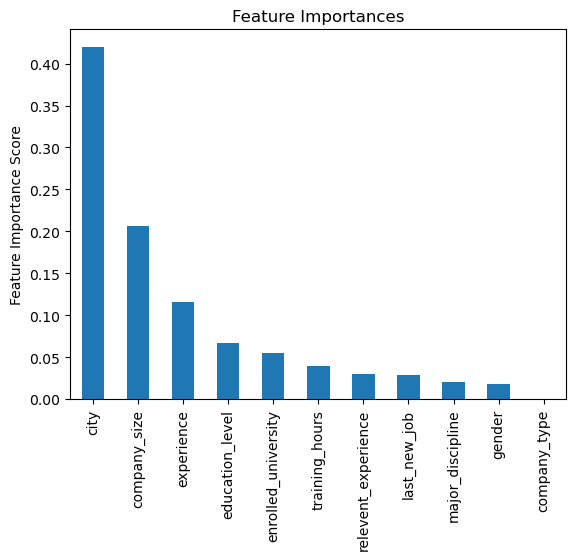

In [113]:
modelfit(gsearch3.best_estimator_, X_train, y_train, predictors)

### Task 8: Find max_features

In [115]:
param_test4 = {'max_features':range(7,20,2)}
gsearch4 = GridSearchCV(estimator = GradientBoostingClassifier(learning_rate=0.2, n_estimators=60,max_depth=6, min_samples_split=900, min_samples_leaf=60, subsample=0.8, random_state=10),
param_grid = param_test4, scoring='roc_auc',n_jobs=4, cv=5)
gsearch4.fit(X_train[predictors],y_train)
gsearch4.best_params_, gsearch4.best_score_

({'max_features': 11}, 0.7982486621365608)


With this we have the final tree-parameters as:

    min_samples_split: 900
    min_samples_leaf: 60
    max_depth: 6
    max_features: 9


### Task 9: Find subsample value

The next step would be try different subsample values.

In [116]:
param_test5 = {'subsample':[0.6,0.7,0.75,0.8,0.85,0.9]}
gsearch5 = GridSearchCV(estimator = GradientBoostingClassifier(learning_rate=0.2, n_estimators=60,max_depth=6,min_samples_split=900, min_samples_leaf=60, subsample=0.8, random_state=10,max_features=9),
param_grid = param_test5, scoring='roc_auc',n_jobs=4, cv=5)
gsearch5.fit(X_train[predictors],y_train)
gsearch5.best_params_, gsearch5.best_score_

({'subsample': 0.85}, 0.7989193819903893)

We got 0.85 as the optimum subsample value.

### Task 10: Improvement

Now, we need to lower the learning rate and increase the number of estimators to see if we get better results.


Model Report
Accuracy : 0.8082774049217002
AUC Score (Train): 0.8400610357992718
cv Score:  0.7989284271452781


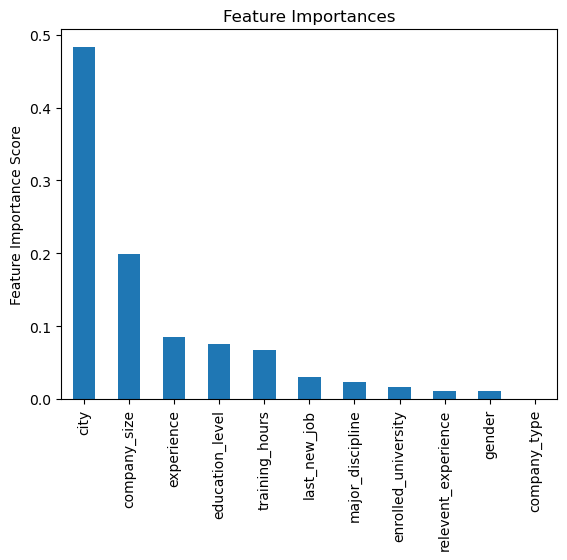

In [118]:
gbm_tuned_1 = GradientBoostingClassifier(learning_rate=0.1, n_estimators=140,max_depth=6, min_samples_split=900,min_samples_leaf=60, subsample=0.8, random_state=10, max_features=9)
modelfit(gbm_tuned_1, X_train, y_train, predictors)

We can see a slight improvement in Accuracy and cv score, lets descrease the learning rate and increase number of estimators one more time.


Model Report
Accuracy : 0.8070842654735272
AUC Score (Train): 0.8386338754615699
cv Score:  0.7999308212584944


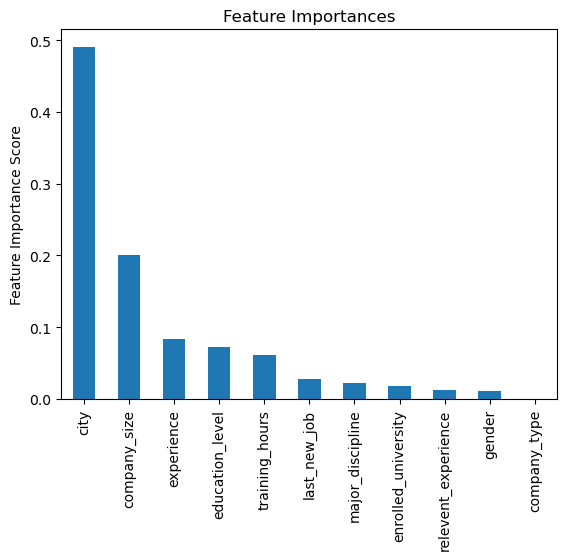

In [119]:
gbm_tuned_2 = GradientBoostingClassifier(learning_rate=0.01, n_estimators=1200,max_depth=6, min_samples_split=900,min_samples_leaf=60, subsample=0.8, random_state=10, max_features=9)
modelfit(gbm_tuned_2, X_train, y_train, predictors)


Model Report
Accuracy : 0.8012677106636839
AUC Score (Train): 0.8278106096997617
cv Score:  0.799234092122175


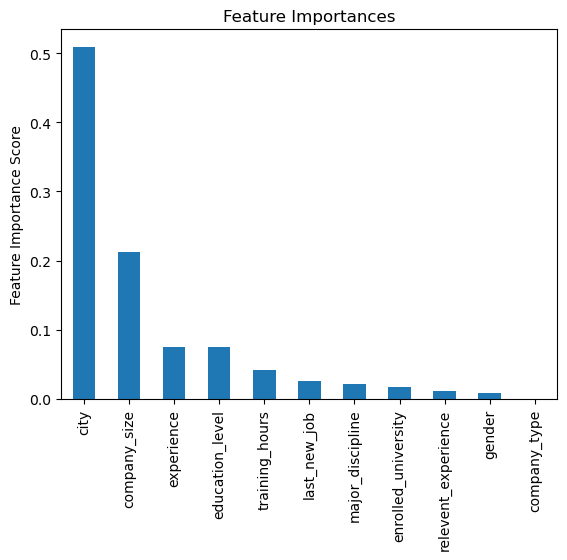

In [120]:
gbm_tuned_3 = GradientBoostingClassifier(learning_rate=0.005, n_estimators=1500,max_depth=6, min_samples_split=900,min_samples_leaf=60, subsample=0.8, random_state=10, max_features=9)
modelfit(gbm_tuned_3, X_train, y_train, predictors)

increasing the number of estimators got us a slightly better model.

### Task 11: Model fitting

Lets fit the model.

In [121]:
gbm_tuned_1.fit(X_train,y_train)

GradientBoostingClassifier(max_depth=6, max_features=9, min_samples_leaf=60,
                           min_samples_split=900, n_estimators=140,
                           random_state=10, subsample=0.8)

In [122]:
X_test[predictors]

,city,gender,relevent_experience,enrolled_university,education_level,major_discipline,experience,company_size,company_type,last_new_job,training_hours
16144,16,2,1,2,0,5,6,7,0,1,21
13661,103,0,1,2,2,2,20,6,0,2,74
344,104,2,1,2,0,5,9,5,0,1,94
1034,21,1,1,2,2,5,15,2,0,1,75
8109,-122,1,0,2,2,5,12,7,0,1,-99
...,...,...,...,...,...,...,...,...,...,...,...
20,-97,1,1,2,2,5,11,6,0,1,68
16600,16,1,1,2,0,5,2,4,0,1,50
13358,16,1,1,2,0,5,17,8,0,2,62
12385,18,1,1,2,0,5,12,7,0,5,28


### Task 12: Prediction

Make predictions on test and training set:

In [123]:
preds = gbm_tuned_1.predict(X_test)

In [124]:
p = gbm_tuned_1.predict(X_train)

In [125]:
print("Accuracy on training set is:")
metrics.accuracy_score(y_train, p)

Accuracy on training set is:


0.8102908277404922

In [126]:
metrics.accuracy_score(y_test, preds)

0.7823590814196242

### Task 13: Result

Save results to a dataframe

In [127]:
output = pd.DataFrame({'enrollee_id ': X_test.enrollee_id , 'target': preds})

In [128]:
output.sample(7)

,enrollee_id,target
18171,-98,0.0
6712,-75,0.0
1288,63,1.0
2074,-113,0.0
2734,-87,0.0
15817,5,0.0
16118,-30,1.0


## Acknowledgments

Thanks to [Omar El Yousfi](https://www.kaggle.com/elyousfiomar) for creating the open-source course [Hyperparameter tuning - Gradient boosting](https://www.kaggle.com/code/elyousfiomar/hyperparameter-tuning-gradient-boosting/notebook#Relevant-experience:). It inspires the majority of the content in this chapter.